In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [11]:
%matplotlib inline
import pandas
import copy
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, \
     ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import cross_validation
from pandas import DataFrame
from collections import defaultdict

# Introduction

This notebook looks the PMT testing for WFP Kakuma. We start first with a preliminary analysis of the data to help identify any issues with pre-processing. We then try various model for proxy means testing and calculate the following values for each model:

* False Positive (FP)
* False Negative (FN)
* True Positive (TP)
* True Negative (TN)

We will also calculate various derivations from the confusion matrix, including:

* Precision
* Accuracy 
* F1 score

We will evaluate the following models for PMT:

* Elastic Net Regression
* Random Forest
* SVC

In [3]:
fname = "/home/ebaumer/Data/kimetrica/vulnerability/wfp_kakuma_pmt.dta"

In [4]:
normalize_data = True

#---------------
# Load data file
#---------------
data = pandas.read_stata(fname)
pandas.set_option('display.max_columns', None)

#-------------------------------------------
# List of response and explanatory variables
#-------------------------------------------
dependent_var = ["below_total_basket"]
dependent_var_con = ["CEE_NG_1d_pc"]

indep_var = ["subcamp","section_1s1q4","simple_coo","recent_arrival",
             "HH_size_analyst","section_1s1q20","section_1s1q21",
             "section_1s1q22","dependency_ratio","true_FHHb","children",
             "CHHb","disabled_b","elderly_b", "n_RC", "section_3s32q1", 
             "section_3s32q5", "section_3s32q6","section_3s32q7", 
             "section_3s32q10","section_3s32q11","crowding_index_sleeprms", 
             "previous_livelihood","has_business","have_employment",
             "rcv_cash_mo"]

#----------------------------------------------------------------------
# Create new variable = Number of Ration Cards / Number of people in HH
#----------------------------------------------------------------------
data["rc_per_hh"] = data["n_RC"] / data["HH_size_analyst"]

#------------------------------------------------------------------------
# Create a new geographic categorical variable based on sub-camp and zone
#------------------------------------------------------------------------
data["loc"] = (data["section_1s1q4"] + (data["subcamp"] - 1)*4)

#------------------------------------
# Plot explanatory variables vs daily 
# non-gifted consumption expenditure
#------------------------------------
log_scl = False
ylabel = "Daily Non-gifted Consumption Expenditure [kshs]"

xlist = ["subcamp","simple_coo","recent_arrival",
         "HH_size_analyst","section_1s1q20","section_1s1q21",
         "section_1s1q22","dependency_ratio","true_FHHb","children",
         "CHHb","disabled_b","elderly_b", "n_RC", "section_3s32q1", 
         "section_3s32q5", "section_3s32q6","section_3s32q7", 
         "section_3s32q10","section_3s32q11","crowding_index_sleeprms", 
         "previous_livelihood","has_business","have_employment","rcv_cash_mo"]

xlist_cmplt = ["subcamp","simple_coo","recent_arrival",
         "HH_size_analyst","section_1s1q20","section_1s1q21",
         "section_1s1q22","dependency_ratio","true_FHHb","children",
         "CHHb","disabled_b","elderly_b", "n_RC", "section_3s32q1", 
         "section_3s32q5", "section_3s32q6","section_3s32q7", 
         "section_3s32q10","section_3s32q11","crowding_index_sleeprms", 
         "previous_livelihood","has_business","have_employment","rcv_cash_mo",
         "below_total_basket","CEE_NG_1d_pc"]

xlabel = ["Sub-camp", "Country of Origin","Recent Arrival", 
          "HH Size","1s1q20","1s1q21","1s1q22", 
          "Number of Dependents per number working age","Gender of HoH", 
          "Number of Children","Child HoH","Disabled Member",
          "Elderly Member","Number of Ration Cards","3s32q1","3s32q5","3s32q6", 
          "3s32q7","3s32q10","3s32q11","Num sleeping rooms per captia",
          "Previous Livelihood","HH has a business",
          "HH has a business or is employed",
          "HH Earned Income Last Month [kshs]"]

#-------------------------------------------------
# Remove high monthly income data point > 700 kshs
#-------------------------------------------------
red_data2 = data[data.CEE_NG_1d_pc < 700]

red_data = red_data2[xlist_cmplt].dropna()
y = red_data[dependent_var_con[0]].values
y_bin = red_data[dependent_var[0]].values
red_data.drop(dependent_var_con[0], axis=1, inplace=True)
red_data.drop(dependent_var[0], axis=1, inplace=True)
#red_data = np.delete(red_data,np.s_[-2:], axis=1)
scld_data = np.zeros(np.shape(red_data.values))
reg_data = np.zeros(np.shape(red_data.values))

#-----------------------
# Covert data to numeric 
#-----------------------
if normalize_data:
    scalarfuncs = {}
    for i,k in enumerate(xlist):
        
        if isinstance(red_data[k].dtype, pandas.core.dtypes.CategoricalDtype):
            xvals = red_data[k].values.labels
        else:
            xvals = red_data[k].values            
        
        scalarfuncs[k] = StandardScaler()
        scld_data[:,i] = scalarfuncs[k].fit_transform(xvals)
        reg_data[:,i] = xvals

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:90: FutureWarning: 'labels' is deprecated. Use 'codes' instead
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int8 was converted to flo

# Preliminary Data Analysis

The preliminary data analysis consists of a high level look at the input parameters and the response variables. There are two key considerations that come from this analysis. 

1. The first consideration is that the data is highly skewed. Meaning that the majority of response varaibles belong to one category. In this case 96% of the response variables belong to the vulnerable class, meaning they are below the poverty threshold. This is illustrated in the figure below. This must be accounted for in the training of the model.
2. The second consideration is that parameters consist of three types of data, binary, categorical, and continuous. 

----------------------------------------------------------------
Total Number of House Holds                = 1968
Total Number of House Holds Vulnerable     = 1886.0 (95.8%)
Total Number of House Holds Not Vulnerable = 82.0 (4.2%)
----------------------------------------------------------------


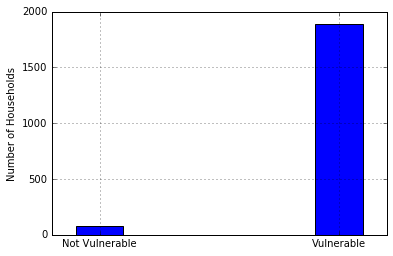

In [5]:
vul_binary = y_bin[~np.isnan(y_bin)]
num_vul = len(np.where(vul_binary==1)[0])
num_not_vul = len(np.where(vul_binary==0)[0])
print "----------------------------------------------------------------"
print "Total Number of House Holds                = {}".format(len(vul_binary))
print "Total Number of House Holds Vulnerable     = {0:} ({1:.1f}%)".format(
    float(num_vul), 
    float(num_vul)/len(vul_binary)*100.)
print "Total Number of House Holds Not Vulnerable = {0:} ({1:.1f}%)".format(
    float(num_not_vul), 
    float(num_not_vul)/len(vul_binary)*100.)
print "----------------------------------------------------------------"


fig, ax = plt.subplots()
ind = np.arange(2)
width = 0.2
vals = [num_not_vul, num_vul]
bars1 = ax.bar(ind,vals, width=width, align='center')
ax.set_ylabel('Number of Households')
#ax.set_xlabel('Vulnerable Indicator')
ax.grid(True)
ax.set_xticks(ind)
ax.set_xticklabels(('Not Vulnerable', 'Vulnerable'))
plt.show()

We will deal with the skewness of the data by doing a continuous regression rather than a logistic regression or a classification. We can build the models based on the continuous prediction variable of daily non-gifted consumption expenditure per house hold and the determination of vulnerable or not can be made from the model output. 

# Determine the Importance of the coefficients

We begin with a Elastic Netregression model. Elastic Net is a regularized regression method that linearly combines the $l_{1}$ and $l_{2}$ penalty function. The $l_{1}$ penalty term imposes sparsity among the coefficients and thus makes the fitted model more interpretable and allows for zeroing or elimination of the coefficients. The $l_{2}$ reguralization limits the size of the coefficient vector. 

Regularizaiton allows for the selection of parameters. Parameters that do not contribute to the response have reduced or zeroed coefficients.


To calculate the performance of the model we split the data into a training and testing set using a k-fold method with 5 folds. Kfold divides all the samples in $k$ groups of samples, called folds of equal size if possible. The model is trained with $k-1$ folds and the fold that is left out is used for testing the model. This is repeated until all folds are tested.

Before training and testing the models we normalize all the data using the standard score or z-scores.

Elastic Net


****************************************************************************************
Pearsons Correlation Coefficient = 0.532 


Input Parameter           Coefficient              
______________________________________________________________________
0, Sub-camp                  -2.155                   
1, Country of Origin         -0.03774                 
2, Recent Arrival            -0.0                     
3, HH Size                   -2.645                   
4, 1s1q20                    0.0                      
5, 1s1q21                    1.291                    
6, 1s1q22                    0.5316                   
7, Number of Dependents per number working age -0.6808                  
8, Gender of HoH             -0.9127                  
9, Number of Children        -1.744                   
10, Child HoH                 0.1113                   
11, Disabled Member           -0.0                     
12, Elderly Member            -0.02409            

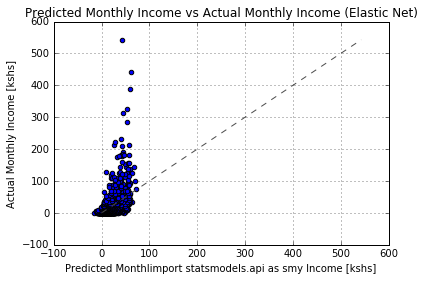

In [6]:
def model_elastic(config):
    
    model = ElasticNet(
        alpha=config['alpha'], 
        l1_ratio=0.5, 
        fit_intercept=config['fit_intercept'], 
        normalize=config['normalize'], 
        max_iter=config['max_iter'], 
        tol=config['tol'], 
        warm_start=config['warm_start'], 
        positive=config['positive'], 
        selection='cyclic'
    )
    return model


#~~~~~~~~~~~~~~~~~~~~~~~
# Elastic Net Regression
#~~~~~~~~~~~~~~~~~~~~~~~
config = {}
config['alpha'] = 1.0
config['fit_intercept'] = True
config['normalize'] = False
config['precompute'] = False
config['max_iter'] = 1000
config['tol'] = 1.0E-4
config['warm_start'] = False
config['positive'] = False

#lasso_model = model_lasso(config)
#lasso_model.fit(scld_data, y)

#ridge_model = model_ridge(config)
#ridge_model.fit(scld_data, y)
elastic_model = model_elastic(config)
elastic_model.fit(scld_data, y)


elastic_model_cv = model_elastic(config)
kf = cross_validation.KFold(len(y), n_folds=2) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score = cross_validation.cross_val_score(elastic_model_cv, 
                                         scld_data, 
                                         y,  
                                         cv=kf, 
                                         n_jobs=2
                                        )

y_pred = elastic_model.predict(scld_data)
r_2, p_val = pearsonr(y_pred, y)
print "Elastic Net"
print "\n"
print "****************************************************************************************"
print "Pearsons Correlation Coefficient = {0:0.3} ".format(r_2)
print "\n"
print "{0:25s} {1:25s}".format("Input Parameter", "Coefficient")
print "______________________________________________________________________"
for i,coefficient in enumerate(elastic_model.coef_):
    print "{0:}, {1:<25s} {2:<25.4}".format(i,xlabel[i],coefficient)

print "****************************************************************************************"

y_max = np.max([np.max(y), np.max(y_pred)])

fig, ax = plt.subplots()
sc = ax.scatter(y_pred, y)
ax.set_ylabel(r"Actual Monthly Income [kshs]")
ax.set_xlabel(r"Predicted Monthlimport statsmodels.api as smy Income [kshs]")
ax.grid(True)
# ax.set_xlim([np.min(red_data[:,1]),np.max(red_data[:,1])])
# ax.set_ylim([np.min(red_data[:,0]),np.max(red_data[:,0])])
diag_line, = ax.plot(np.arange(y_max), np.arange(y_max), ls="--", c=".3")
ax.set_title("Predicted Monthly Income vs Actual Monthly Income (Elastic Net)")
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()



It is evident from the above graph that a regular type regression does not model the monthly income in any adequate manner.

We will next try a random forest model.



****************************************************************************************
Pearsons Correlation Coefficient = 0.961 


Input Parameter           Importance               
______________________________________________________________________
0, Sub-camp                  0.06147                  
1, Country of Origin         0.04014                  
2, Recent Arrival            0.01679                  
3, HH Size                   0.08526                  
4, 1s1q20                    0.03369                  
5, 1s1q21                    0.02666                  
6, 1s1q22                    0.02524                  
7, Number of Dependents per number working age 0.02453                  
8, Gender of HoH             0.02436                  
9, Number of Children        0.04536                  
10, Child HoH                 0.01017                  
11, Disabled Member           0.01437                  
12, Elderly Member            0.006331                 
13, Nu

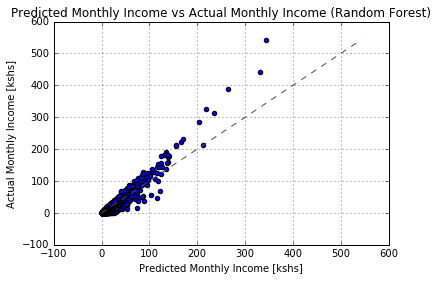

In [7]:
def model_RF():
    model = ExtraTreesRegressor(
        n_estimators=100, 
        criterion='mse',
        max_depth=None,
        min_samples_split=2, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0., 
        random_state=None, 
        verbose=0, 
        max_leaf_nodes=None, 
        oob_score=False,
        bootstrap=True,
        warm_start=False,
    )    
    return model


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Extremly Random Forest
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
inds = [0,3,5,6,7,8,9,14,15,16,17,18,19,20,22,23,24]
red_reg_data = reg_data[:,inds]

randfor_model_cv = model_elastic(config)
kf = cross_validation.KFold(len(y), n_folds=2) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score2 = cross_validation.cross_val_score(randfor_model_cv, 
                                         reg_data, 
                                         y,  
                                         cv=kf, 
                                         n_jobs=2
                                        )



rand_for_model = model_RF()
rand_for_model.fit(reg_data, y)

y_pred = rand_for_model.predict(reg_data)

r_2, p_val = pearsonr(y_pred, y)
print "\n"
print "****************************************************************************************"
print "Pearsons Correlation Coefficient = {0:0.3} ".format(r_2)
print "\n"
print "{0:25s} {1:25s}".format("Input Parameter", "Importance")
print "______________________________________________________________________"
for i,coefficient in enumerate(rand_for_model.feature_importances_):
    print "{0:}, {1:<25s} {2:<25.4}".format(i,xlabel[i],coefficient)

print "****************************************************************************************"



y_max = np.max([np.max(y), np.max(y_pred)])

fig, ax = plt.subplots()
sc = ax.scatter(y_pred, y)
ax.set_ylabel(r"Actual Monthly Income [kshs]")
ax.set_xlabel(r"Predicted Monthly Income [kshs]")
ax.grid(True)
# ax.set_xlim([np.min(red_data[:,1]),np.max(red_data[:,1])])
# ax.set_ylim([np.min(red_data[:,0]),np.max(red_data[:,0])])
diag_line, = ax.plot(np.arange(y_max), np.arange(y_max), ls="--", c=".3")
ax.set_title("Predicted Monthly Income vs Actual Monthly Income (Random Forest)")
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

We calculate the precision and recall along with the number of true positives (TP), false positive (FP), true negatives (TN), false negatives (FN).

The following matrix shows the definitions of TP, FP, TN, and FN:

<img src="files/fig11.png">


The precision is defined as:
$$Precision = \frac{TP}{TP + FP}$$

The recall is defined as:
$$Recall = \frac{TP}{TP + FN}$$



In [9]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_actual = y_actual.astype(int)
    y_hat = y_hat.astype(int)

    for j in range(len(y_hat)):
        if y_hat[j] & y_actual[j]:     #TP
            TP += 1.
        elif y_hat[j] & ~y_actual[j]:  #FP
            FP += 1.
        elif ~y_hat[j] & y_actual[j]:  #FN
            FN += 1.
        elif ~y_hat[j] & ~y_actual[j]: #TN
            TN += 1. 

    return(TP, FP, TN, FN)

#--------------------------------------
# Convert continuous response to binary
#--------------------------------------
inds1 = np.where(y_pred < 77)[0]
inds2 = np.where(y_pred >= 77)[0]
y_pred_bin = np.zeros(len(y_pred))

y_pred_bin[inds1] = 1

precision = skl.metrics.precision_score(y_bin, y_pred_bin)
recall = skl.metrics.recall_score(y_bin, y_pred_bin)
f1_score = skl.metrics.f1_score(y_bin, y_pred_bin)
(TP, FP, TN, FN) = perf_measure(y_bin, y_pred_bin)


print "Precision = {}".format(precision)
print "Recall    = {}".format(recall)
print "F1 score  = {}".format(f1_score)
print "Number of True Positives  = {}".format(TP)
print "Number of False Positives = {}".format(FP)
print "Number of True Negatives  = {}".format(TN)
print "Number of False Negatives = {}".format(FN)

Precision = 0.987901104682
Recall    = 0.995758218452
F1 score  = 0.991814100871
Number of True Positives  = 1878.0
Number of False Positives = 23.0
Number of True Negatives  = 59.0
Number of False Negatives = 8.0


# Logistic Regression

We now try a logistic regression using a class weighting to account for the skewed data.


In [10]:
def model_LR():
    
    model = LogisticRegression(
        penalty='l2',
        dual=False, 
        tol=1e-4, 
        C=1.0, 
        class_weight='balanced', 
        max_iter=300
    )

    return model

#--------------------
# Logistic Regression
#--------------------
logreg_model = model_LR()
logreg_model.fit(scld_data, y_bin)


logreg_model_cv = model_LR()
kf = cross_validation.KFold(len(y_bin), n_folds=2) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score = cross_validation.cross_val_score(logreg_model_cv, 
                                         scld_data, 
                                         y_bin,  
                                         cv=kf, 
                                         n_jobs=2
                                        )

y_pred = logreg_model.predict(scld_data)
print "Logistic Regression"
print "\n"
print "{0:25s} {1:25s}".format("Input Parameter", "Coefficient")
print "______________________________________________________________________"
for i,coefficient in enumerate(logreg_model.coef_[0]):
    print "{0:}, {1:<25s} {2:<25.4}".format(i,xlabel[i],coefficient)

print "****************************************************************************************"
precision = skl.metrics.precision_score(y_bin, y_pred)
recall = skl.metrics.recall_score(y_bin, y_pred)
f1_score = skl.metrics.f1_score(y_bin, y_pred)
(TP, FP, TN, FN) = perf_measure(y_bin, y_pred)


print "Precision = {}".format(precision)
print "Recall    = {}".format(recall)
print "F1 score  = {}".format(f1_score)
print "Number of True Positives  = {}".format(TP)
print "Number of False Positives = {}".format(FP)
print "Number of True Negatives  = {}".format(TN)
print "Number of False Negatives = {}".format(FN)



Logistic Regression


Input Parameter           Coefficient              
______________________________________________________________________
0, Sub-camp                  0.4657                   
1, Country of Origin         0.03319                  
2, Recent Arrival            -0.2505                  
3, HH Size                   2.368                    
4, 1s1q20                    0.1346                   
5, 1s1q21                    -0.4935                  
6, 1s1q22                    -0.2104                  
7, Number of Dependents per number working age 0.4662                   
8, Gender of HoH             0.3009                   
9, Number of Children        -0.3889                  
10, Child HoH                 -0.06718                 
11, Disabled Member           -0.1791                  
12, Elderly Member            0.08544                  
13, Number of Ration Cards    -0.1022                  
14, 3s32q1                    -0.7755                  
15, 3s3

# SVC


In [12]:
def model_SVC():
    model = SVC(
        C=1.0, 
        kernel='rbf', 
        degree=3, 
        gamma='auto', 
        coef0=0.0, 
        probability=True, 
        tol=1e-3, 
        cache_size=200, 
        class_weight='balanced', 
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None
    )
    return model

svc_model = model_SVC()
svc_model.fit(scld_data, y_bin)


svc_model_cv = model_SVC()
kf = cross_validation.KFold(len(y_bin), n_folds=2) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score = cross_validation.cross_val_score(svc_model_cv, 
                                         scld_data, 
                                         y_bin,  
                                         cv=kf, 
                                         n_jobs=2
                                        )

y_pred = svc_model.predict(scld_data)

print "SVC"
print "****************************************************************************************"
precision = skl.metrics.precision_score(y_bin, y_pred)
recall = skl.metrics.recall_score(y_bin, y_pred)
f1_score = skl.metrics.f1_score(y_bin, y_pred)
(TP, FP, TN, FN) = perf_measure(y_bin, y_pred)


print "Precision = {}".format(precision)
print "Recall    = {}".format(recall)
print "F1 score  = {}".format(f1_score)
print "Number of True Positives  = {}".format(TP)
print "Number of False Positives = {}".format(FP)
print "Number of True Negatives  = {}".format(TN)
print "Number of False Negatives = {}".format(FN)


SVC
****************************************************************************************
Precision = 0.999452654625
Recall    = 0.968186638388
F1 score  = 0.983571236197
Number of True Positives  = 1826.0
Number of False Positives = 1.0
Number of True Negatives  = 81.0
Number of False Negatives = 60.0


# Random Forest Classifier

In [13]:
def model_RFC():
    model = ExtraTreesClassifier(
        n_estimators=100, 
        criterion="gini", 
        class_weight='balanced'
    )
    return model

#--------------------------
# Random Forest classifier
#--------------------------
rfc_model = model_RFC()
rfc_model.fit(scld_data, y_bin)


rfc_model_cv = model_RFC()
kf = cross_validation.KFold(len(y_bin), n_folds=2) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score = cross_validation.cross_val_score(rfc_model_cv, 
                                         scld_data, 
                                         y_bin,  
                                         cv=kf, 
                                         n_jobs=2
                                        )

y_pred = rfc_model.predict(scld_data)
print "Random Forest Classifier"

print "****************************************************************************************"
precision = skl.metrics.precision_score(y_bin, y_pred)
recall = skl.metrics.recall_score(y_bin, y_pred)
f1_score = skl.metrics.f1_score(y_bin, y_pred)
(TP, FP, TN, FN) = perf_measure(y_bin, y_pred)


print "Precision = {}".format(precision)
print "Recall    = {}".format(recall)
print "F1 score  = {}".format(f1_score)
print "Number of True Positives  = {}".format(TP)
print "Number of False Positives = {}".format(FP)
print "Number of True Negatives  = {}".format(TN)
print "Number of False Negatives = {}".format(FN)

Random Forest Classifier
****************************************************************************************
Precision = 1.0
Recall    = 1.0
F1 score  = 1.0
Number of True Positives  = 1886.0
Number of False Positives = 0
Number of True Negatives  = 82.0
Number of False Negatives = 0
